In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from importlib import reload
from neurobiases import TriangularModel, TCSolver, EMSolver
from neurobiases import utils, plot
%matplotlib inline

In [49]:
# create triangular model kwargs
# importantly, we apply some sparsity to both sets of parameters
tuning_kwargs, coupling_kwargs, noise_kwargs, stim_kwargs = \
    TriangularModel.generate_kwargs(
        M=60, N=25, K=1,
        corr_cluster=0.1, corr_back=0.0,
        coupling_loc=-1.5, coupling_scale=0.25,
        tuning_sparsity=0.6, coupling_sparsity=0.5,
        tuning_random_state=2332, coupling_random_state=2332)

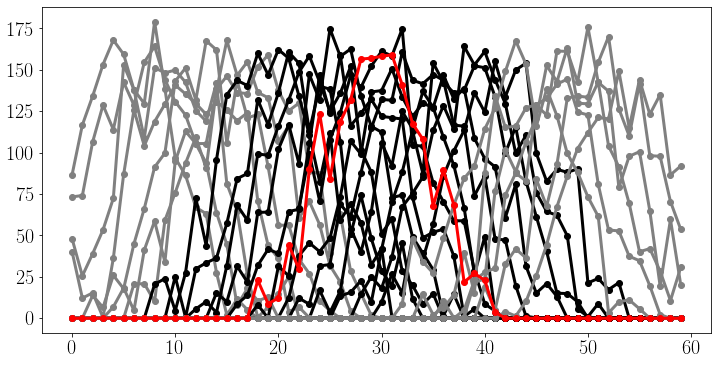

In [50]:
# create triangular model and examine tuning curves
tm = TriangularModel(
    model='linear',
    parameter_design='direct_response',
    tuning_kwargs=tuning_kwargs,
    coupling_kwargs=coupling_kwargs,
    noise_kwargs=noise_kwargs,
    stim_kwargs=stim_kwargs
)
tm.plot_tuning_curves(neuron='all')
plt.show()

In [102]:
n_reps = 100
n_samples = 1000
a_true = tm.a.ravel()
a_mask = a_true != 0
b_true = tm.b.ravel()
b_mask = b_true != 0
a_coefs = np.zeros((n_reps, tm.N))
b_coefs = np.zeros((n_reps, tm.M))

In [103]:
for rep in range(n_reps):
    X, Y, y = tm.generate_samples(n_samples)
    solver = TCSolver(X, Y, y,
                      a_mask=a_mask,
                      b_mask=b_mask)
    a_coefs[rep], b_coefs[rep] = solver.fit_ols()

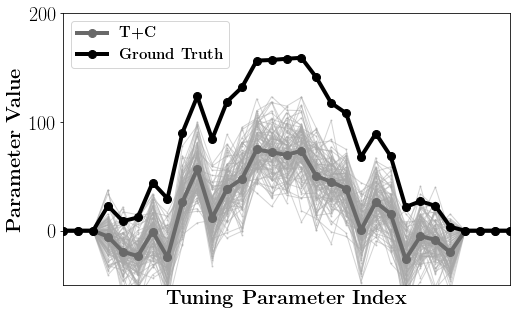

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
[ax.plot(np.arange(tm.M),
         b_coefs[rep],
         color='darkgray',
         alpha=0.5,
         marker='o',
         markersize=1,
         linewidth=1)
 for rep in range(n_reps)]
ax.plot(np.arange(tm.M), b_coefs.mean(axis=0),
        color='dimgray',
        marker='o',
        markersize=8,
        linewidth=4,
        label=r'\textbf{T+C}')
ax.plot(np.arange(tm.M), b_true,
        color='k',
        marker='o',
        linewidth=4,
        markersize=8,
        label=r'\textbf{Ground Truth}')

ax.set_xlim([15, 45])
ax.set_ylim([-50, 200])
ax.set_yticks([0, 100, 200])
ax.set_xticks([])
ax.set_xlabel(r'\textbf{Tuning Parameter Index}', fontsize=20)
ax.set_ylabel(r'\textbf{Parameter Value}', fontsize=20)
ax.legend(loc=2, prop={'size': 15})
plt.savefig('seb_tc.pdf', bbox_inches='tight')
plt.show()

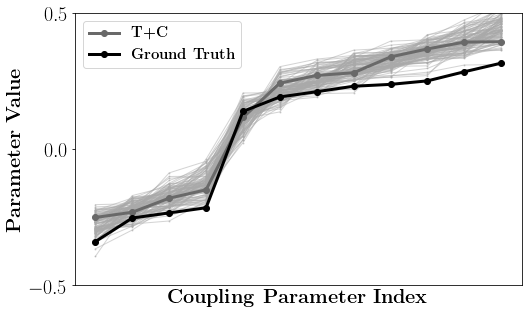

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

[ax.plot(np.arange(a_mask.sum()),
         np.sort(a_coefs[rep][a_mask]),
         color='darkgray',
         alpha=0.5,
         marker='o',
         markersize=1,
         linewidth=1)
 for rep in range(n_reps)]
ax.plot(np.arange(a_mask.sum()), np.sort(a_coefs.mean(axis=0)[a_mask]),
        color='dimgray',
        marker='o',
        linewidth=3,
        label=r'\textbf{T+C}')
ax.plot(np.arange(a_mask.sum()), np.sort(a_true[a_mask]),
        color='k',
        marker='o',
        linewidth=3,
        label=r'\textbf{Ground Truth}')
#ax.set_xlim([15, 45])
ax.set_ylim([-0.5, 0.5])
ax.set_yticks([-0.5, 0, 0.5])
ax.set_xticks([])
ax.set_xlabel(r'\textbf{Coupling Parameter Index}', fontsize=20)
ax.set_ylabel(r'\textbf{Parameter Value}', fontsize=20)
ax.legend(loc=2, prop={'size': 15})
plt.savefig('seb_tc_coupling.pdf', bbox_inches='tight')
plt.show()

In [87]:
n_deltas = 100
deltas = np.linspace(-50, 150, n_deltas)
a_start = tm.a.ravel()
b_start = tm.b.ravel()
a_coefs = np.zeros((n_deltas, tm.N))
b_coefs = np.zeros((n_deltas, tm.M))

In [88]:
# calculate tuning/coupling parameters for each identifiability parameters
for idx, delta in enumerate(deltas):
    a, b, _, _ = tm.identifiability_transform(delta=delta, update=False)
    a_coefs[idx] = a.ravel()
    b_coefs[idx] = b.ravel()

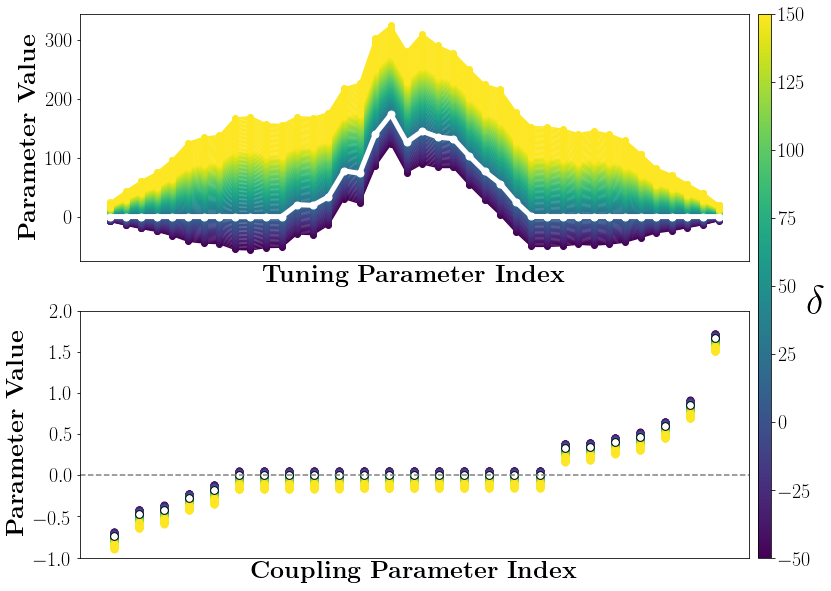

In [124]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

for idx in range(n_deltas):
    color = plot.get_cmap_color(cmap='viridis', val=deltas[idx], min_val=-50, max_val=150)
    axes[0].plot(
        np.arange(tm.M), b_coefs[idx],
        marker='o',
        color=color)
    axes[1].scatter(
        np.arange(tm.N), np.sort(a_coefs[idx]),
        marker='o',
        s=50,
        color=color)
    
axes[0].plot(np.arange(tm.M), b_start,
             color='white',
             linewidth=5,
             marker='o',
             markersize=7)
axes[1].scatter(
    np.arange(tm.N), np.sort(a_start),
    color='white',
    edgecolor='black',
    marker='o',
    s=60)

axes[1].axhline(0, color='gray', linestyle='--')
axes[1].set_ylim([-1, 2])

for ax in axes:
    ax.set_xticks([])
    
axes[0].set_xlabel(r'\textbf{Tuning Parameter Index}', fontsize=25)
axes[1].set_xlabel(r'\textbf{Coupling Parameter Index}', fontsize=25)
axes[0].set_ylabel(r'\textbf{Parameter Value}', fontsize=25)
axes[1].set_ylabel(r'\textbf{Parameter Value}', fontsize=25)

cax = fig.add_axes([axes[1].get_position().x1 + 0.01,
                    axes[1].get_position().y0,
                    0.015,
                    axes[0].get_position().y1 - axes[1].get_position().y0])

norm = mpl.colors.Normalize(vmin=-50,vmax=150)
cb = mpl.colorbar.ColorbarBase(cax, norm=norm, cmap=plt.get_cmap('viridis'))
cb.set_label(r'$\delta$', fontsize=40, rotation=0)
plt.savefig('structure_non_identifiability.pdf', bbox_inches='tight')
plt.show()